In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import importlib
# import sys
# sys.path.append('/home/users/mgotsmy/sweat/210000_notebooks/210831_big_model_imputed/210909_random_data/')
import extended_model as em
import pickle
from sklearn.metrics import r2_score
import scipy.stats as ss
from itertools import combinations

# helper functions

In [159]:
def significance_star(pvalue):
    '''
    Prints correct number of stars for the significance level.
    -
    Input
    pvalue      value of probability
    -
    Output      
    string      string with correct number of stars for significant results and - for no significance
    '''
    
    assert pvalue >= 0
    
    if pvalue <= .001:
        return '***'
    elif pvalue <= .01:
        return '**'
    elif pvalue <= .05:
        return '*'
    else:
        return '-'
    
def SSE(true,fit):
    return np.sum((true-fit)**2)

def SD(true,fit):
    return np.sqrt(np.sum((true-fit)**2)/len(true))

def r2(true,fit):
    return r2_score(true,fit)

def spearmanr(true,fit):
    return ss.spearmanr(true,fit).correlation

def pearsonr(true,fit):
    return ss.pearsonr(true,fit)[0]

def relative_error(true,fit):
    rE = (true-fit)/true
    return np.mean(np.abs(rE))

def ratio_SD(true,fit):
    y = fit/true
    return np.std(y/np.mean(y))

diagnosis = {'SSE':SSE,
             'r2':r2,
             'spearman':spearmanr,
             'pearson':pearsonr,
             'rE':relative_error,
             'SD':SD,
             'ratio_SD':ratio_SD,
            }

In [135]:
def plot_performance(diagnosis_name,results_sv):
    diagnosis_func = diagnosis[diagnosis_name]
    maximum = 0
    # list of all goodness of fit estimates
    tmp_pqn      = []
    tmp_em_full  = []
    tmp_mix_full = []
    tmp_em_mini  = []
    tmp_mix_mini = []
    # read out how many replicates there are in the dataset
    n_replicates = len(results_sv['PQN'])
    # loop over all replicates
    for n_replicate in range(n_replicates):
        sv_vector  = results_sv['TRUE'][n_replicate]
        # loop over all normalization methods
        for method, tmp_list in zip(['PQN','EM_full','EM_mini','MIX_full','MIX_mini'],[tmp_pqn,tmp_em_full,tmp_em_mini,tmp_mix_full,tmp_mix_mini]):
            tmp_sv = results_sv[method][n_replicate]
            tmp_diagnosis = diagnosis_func(sv_vector,tmp_sv)
            tmp_list.append(tmp_diagnosis)
        
    # plot the diagnosis parameters
    rand = np.random.uniform(-.1,.1,n_replicates)
    nr = 0
    colors = ['b','r','r','y','y']
    for method, tmp_list in zip(['PQN','EM_full','EM_mini','MIX_full','MIX_mini'],[tmp_pqn,tmp_em_full,tmp_em_mini,tmp_mix_full,tmp_mix_mini]):
        plt.scatter(np.ones(n_replicates)*nr+rand,tmp_list,color=colors[nr],marker='.',s=20,edgecolor='k',linewidth=.2)
        plt.plot([nr-.2,nr+.2],[np.mean(tmp_list),np.mean(tmp_list)],color='k')
        print('{:10} mean = {:5.3f} std = {:5.3f}'.format(method,np.mean(tmp_list),np.std(tmp_list)))
        nr += 1
        

    # significances
    tmp_dic = {'PQN':tmp_pqn,'EM_full':tmp_em_full,'EM_mini':tmp_em_mini,'MIX_full':tmp_mix_full,'MIX_mini':tmp_mix_mini}
    tmp_loc = {'PQN':0,'EM_full':1,'EM_mini':2,'MIX_full':3,'MIX_mini':4}
    if np.max([tmp_pqn,tmp_em_full,tmp_em_mini,tmp_mix_full,tmp_mix_mini]) > maximum:
        maximum = np.max([tmp_pqn,tmp_em_full,tmp_em_mini,tmp_mix_full,tmp_mix_mini])
    height          = maximum*1.1
    bracket_size    = .01
    text_offset     = .01
    height_increase = .05*maximum
    for i,j in combinations(tmp_dic.keys(),2):
        test_result = ss.mannwhitneyu(tmp_dic[i],tmp_dic[j])
        if test_result.pvalue <= .05:
                plt.plot(np.array([tmp_loc[i],tmp_loc[i],tmp_loc[j],tmp_loc[j]]),
                         [height-maximum*bracket_size,height,height,height-maximum*bracket_size],
                         'k',
                         linewidth=.5
                        )
                plt.text(np.mean([tmp_loc[i],tmp_loc[j]]),
                         height+maximum*text_offset,
                         significance_star(test_result.pvalue),
                         ha='center',
                         va='center',
                         fontsize=8
                        )
                height += height_increase
    return nr

def plot_points(diagnosis_name,results_sv):
    diagnosis_func = diagnosis[diagnosis_name]
    maximum = 0
    # list of all goodness of fit estimates
    tmp_pqn      = []
    tmp_em_full  = []
    tmp_mix_full = []
    tmp_em_mini  = []
    tmp_mix_mini = []
    # read out how many replicates there are in the dataset
    n_replicates = len(results_sv['PQN'])
    # loop over all replicates
    for n_replicate in range(n_replicates):
        sv_vector  = results_sv['TRUE'][n_replicate]
        # loop over all normalization methods
        for method, tmp_list in zip(['PQN','EM_full','EM_mini','MIX_full','MIX_mini'],[tmp_pqn,tmp_em_full,tmp_em_mini,tmp_mix_full,tmp_mix_mini]):
            tmp_sv = results_sv[method][n_replicate]
            tmp_diagnosis = diagnosis_func(sv_vector,tmp_sv)
            tmp_list.append(tmp_diagnosis)
    
    means = []
    stds   = []
    for tmp_list in [tmp_pqn,tmp_em_full,tmp_em_mini,tmp_mix_full,tmp_mix_mini]:
        means.append(np.mean(tmp_list))
        stds.append(np.std(tmp_list))
    return means, stds

# Plot Single Result

PQN        mean = 0.267 std = 0.142
EM_full    mean = 0.272 std = 0.123
EM_mini    mean = 0.594 std = 0.230
MIX_full   mean = 0.254 std = 0.111
MIX_mini   mean = 0.199 std = 0.077


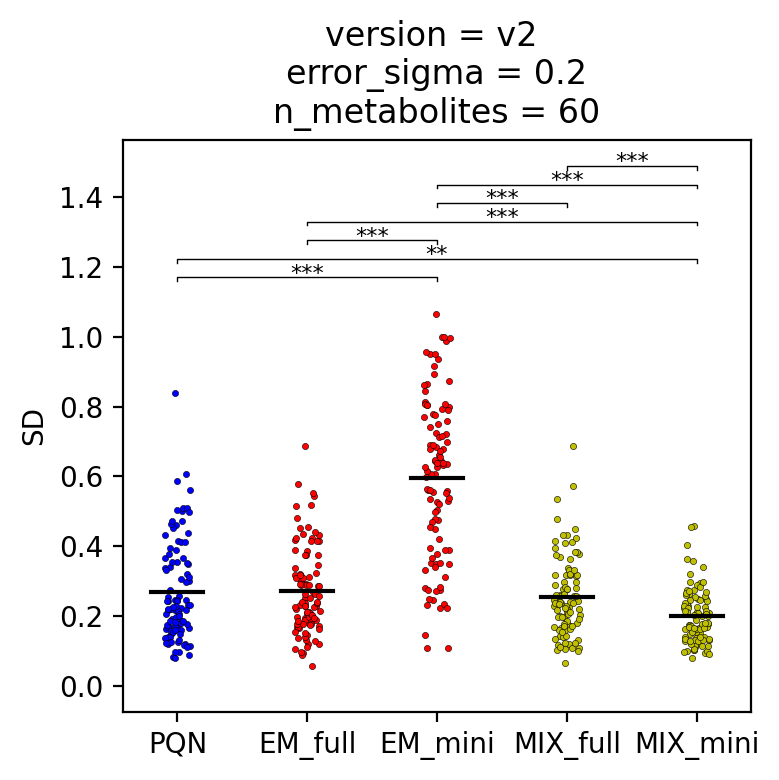

In [161]:
# load data
error_sigma   = .2
n_metabolites = 60
path          = 'v2'
base          = '/home/users/mgotsmy/paper_gits/211109_sweat_normalization_github/sweat_normalization/simulation_results'
with open(f'{base}/{path}_e_{error_sigma}_n_{n_metabolites}.pkl','rb') as file:
    results_time,results_sv,results_model,raw_values = pickle.load(file)
    
plt.figure(dpi=200,figsize=(4,4))
plt.title('version = {} \nerror_sigma = {:.1f}\nn_metabolites = {}'.format(path,error_sigma,n_metabolites))

diagnosis_name = 'SD'
nr = plot_performance(diagnosis_name,results_sv)
plt.ylabel(diagnosis_name)
plt.plot(0,0,color='b',label='PQN')
plt.plot(0,0,color='r',label='EM')
plt.plot(0,0,color='y',label='MIX')
plt.xticks(range(nr),['PQN','EM_full','EM_mini','MIX_full','MIX_mini'])
# plt.legend(fancybox=False,edgecolor='k')#,loc='lower right')
plt.tight_layout()
plt.show()

# Plot increasing n_metabolites

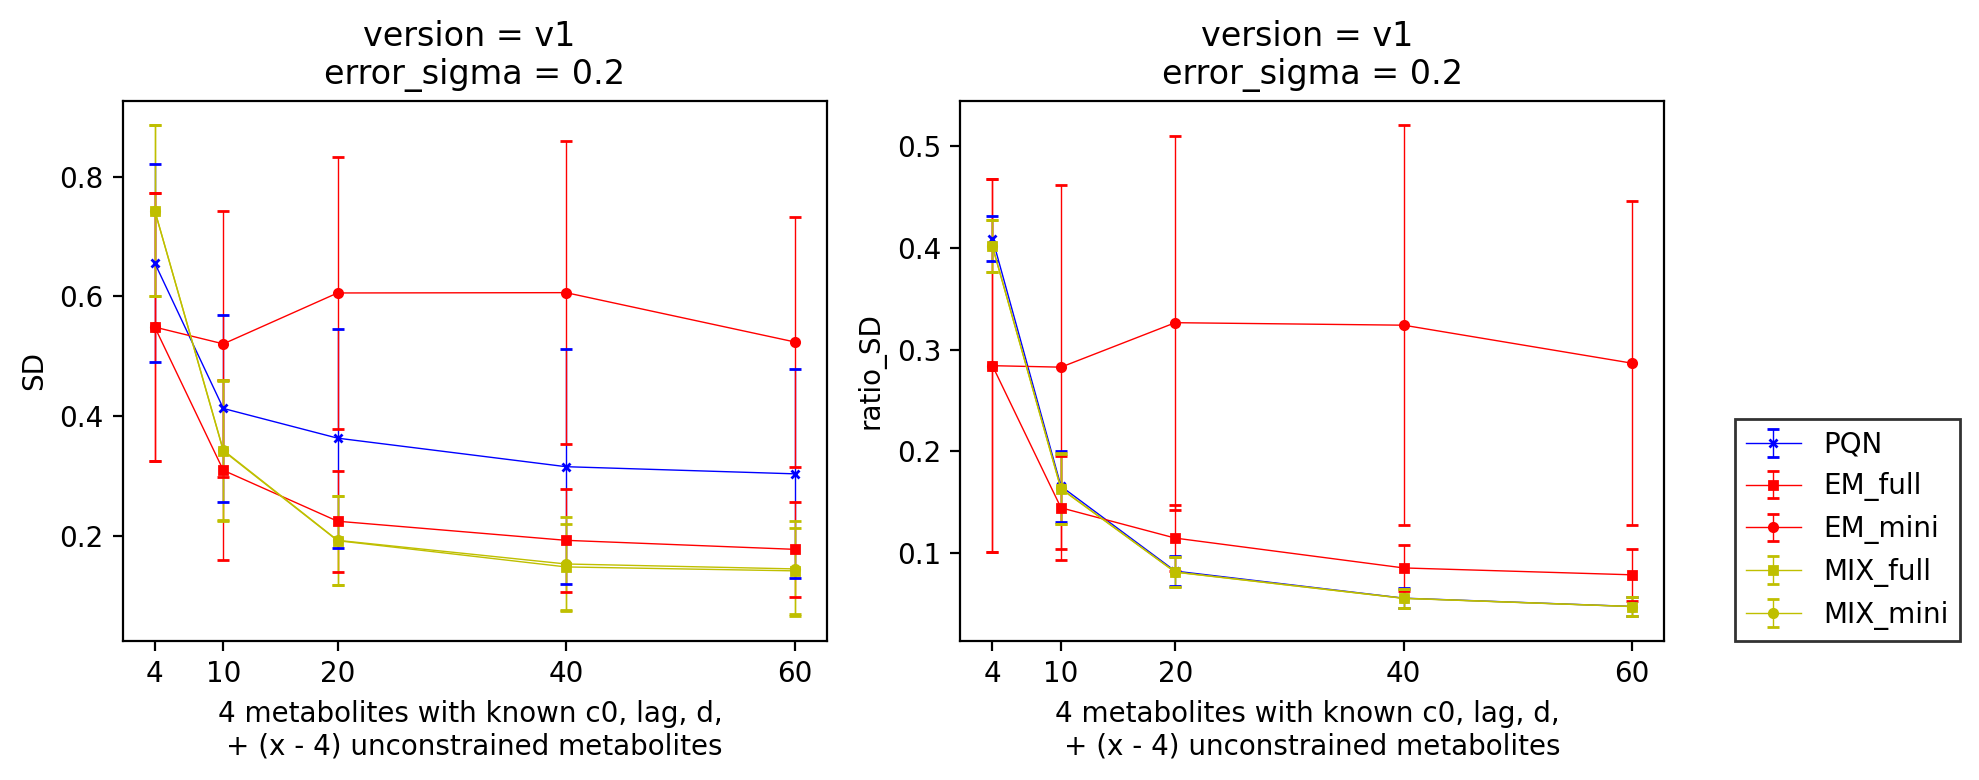

In [163]:
# load data
error_sigma   = .2
path          = 'v1'
base          = '/home/users/mgotsmy/paper_gits/211109_sweat_normalization_github/sweat_normalization/simulation_results'
n_metabolites_list = np.array([4,10,20,40,60])
markers = ['x','s','o','s','o']
colors  = ['b','r','r','y','y']
methods = ['PQN','EM_full','EM_mini','MIX_full','MIX_mini']

plt.figure(dpi=200,figsize=(10,4))


######## Subplot 1
plt.subplot(121)
plt.title('version = {} \nerror_sigma = {:.1f}'.format(path,error_sigma))
diagnosis_name = 'SD'
plt.ylabel(f'{diagnosis_name}')
points = []
stds   = []
for n_metabolites in n_metabolites_list:
    with open(f'{base}/{path}_e_{error_sigma}_n_{n_metabolites}.pkl','rb') as file:
        results_time,results_sv,results_model,raw_values = pickle.load(file)
    tmp, std = plot_points(diagnosis_name,results_sv)
    points.append(tmp)
    stds.append(std)
points = np.array(points)
stds = np.array(stds)
for nr, label in enumerate(methods):
    plt.errorbar(n_metabolites_list,points[:,nr],yerr=stds[:,nr],color=colors[nr],marker=markers[nr],linewidth=.5,capsize=2,label=label,markersize=3)
plt.xlabel('4 metabolites with known c0, lag, d, \n+ (x - 4) unconstrained metabolites')
plt.xticks(n_metabolites_list)
# plt.ylim(0,1)

######## Subplot 2
plt.subplot(122)
plt.title('version = {} \nerror_sigma = {:.1f}'.format(path,error_sigma))
diagnosis_name = 'ratio_SD'
plt.ylabel(f'{diagnosis_name}')
points = []
stds   = []
for n_metabolites in n_metabolites_list:
    with open(f'{base}/{path}_e_{error_sigma}_n_{n_metabolites}.pkl','rb') as file:
        results_time,results_sv,results_model,raw_values = pickle.load(file)
    tmp, std = plot_points(diagnosis_name,results_sv)
    points.append(tmp)
    stds.append(std)
points = np.array(points)
stds = np.array(stds)
for nr, label in enumerate(methods):
    plt.errorbar(n_metabolites_list,points[:,nr],yerr=stds[:,nr],color=colors[nr],marker=markers[nr],linewidth=.5,capsize=2,label=label,markersize=3)
plt.xlabel('4 metabolites with known c0, lag, d, \n+ (x - 4) unconstrained metabolites')
plt.xticks(n_metabolites_list)
# plt.ylim(0,1)

######## Concluding Commands
plt.legend(loc=(1.1,0),edgecolor='k',fancybox=False)
plt.tight_layout()
plt.show()

# Plot Fitting Time

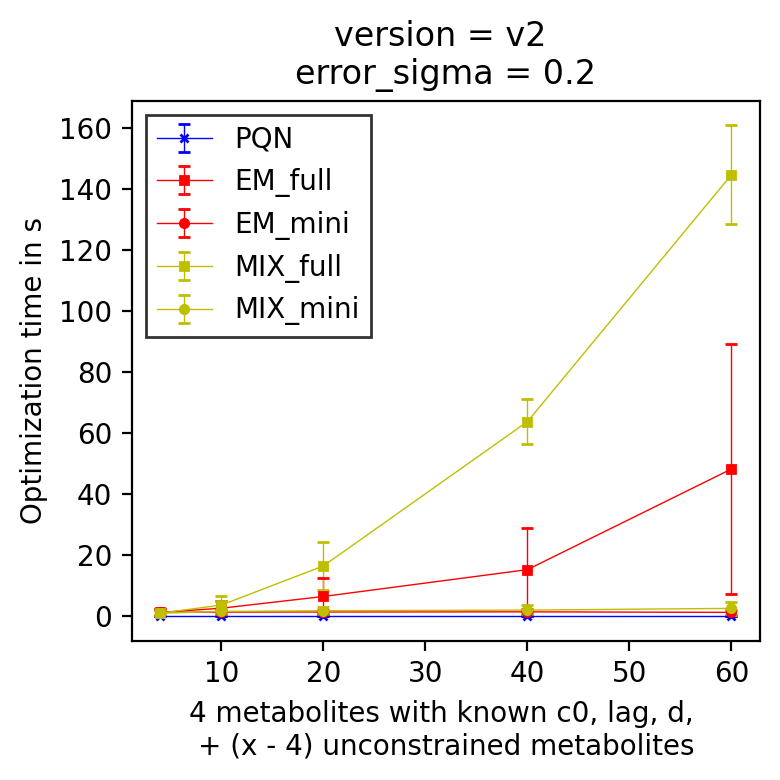

In [140]:
# load data
error_sigma   = .2
path          = 'v2'
base          = '/home/users/mgotsmy/paper_gits/211109_sweat_normalization_github/sweat_normalization/simulation_results'
n_metabolites_list = np.array([4,10,20,40,60])
markers = ['x','s','o','s','o']
colors  = ['b','r','r','y','y']
methods = ['PQN','EM_full','EM_mini','MIX_full','MIX_mini']

total_times = []
total_stds  = []
for n_metabolites in n_metabolites_list:
    with open(f'{base}/{path}_e_{error_sigma}_n_{n_metabolites}.pkl','rb') as file:
        results_time,results_sv,results_model,raw_values = pickle.load(file)
    tmp_times = []
    tmp_stds  = []
    for method in methods:
        tmp_times.append(np.mean(results_time[method]))
        tmp_stds.append(np.std(results_time[method]))
    total_times.append(tmp_times)
    total_stds.append(tmp_stds)
total_times = np.array(total_times)
total_stds  = np.array(total_stds)

plt.figure(dpi=200,figsize=(4,4))
plt.title('version = {} \nerror_sigma = {:.1f}'.format(path,error_sigma))
for nr, label in enumerate(methods):
    plt.errorbar(n_metabolites_list,total_times[:,nr],yerr=total_stds[:,nr],color=colors[nr],marker=markers[nr],linewidth=.5,capsize=2,label=label,markersize=3)
plt.xlabel('4 metabolites with known c0, lag, d, \n+ (x - 4) unconstrained metabolites')
plt.ylabel('Optimization time in s')
# plt.yscale('log')
######## Concluding Commands
plt.legend(edgecolor='k',fancybox=False) # loc=(1.1,0),
plt.tight_layout()
plt.show()